In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras_preprocessing.image import load_img
from PIL import ImageOps
import cv2
keras.backend.clear_session()
import time
import tensorflow_examples

2022-12-15 16:16:21.143808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 16:16:21.251217: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 16:16:21.652284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2022-12-15 16:16:21.652329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

# Load and preview dataset

In [2]:
start = time.time()

# Change to path where images and masks are stored
path_to_folder = 'downloaded_images'

input_paths = []
target_paths = []
for root, dirs, files in os.walk(path_to_folder):
    for file in files:
        path = os.path.join(root, file)

        if file == '.DS_Store':
            continue
       
        if 'mask' in file:
            target_paths.append(path)
        else:
            input_paths.append(path)

print(f"Data size: {len(input_paths)}")
print(f"Data size: {len(target_paths)}")
input_paths.sort()
target_paths.sort()

Data size: 477
Data size: 477


## Sample corresponding mask and image to visualize

In [4]:


num_samples = 0
k = 0
for i in range(num_samples):
    plt.figure(figsize=(20, 28))
    print(f"Sample number {i}")
    plt.subplot(num_samples, 2, 1 + k * 2)
    plt.imshow(load_img(input_paths[i], target_size=(512, 512), color_mode="rgb"))
    plt.title("Image")

    
    plt.subplot(num_samples, 2, 2 + k*2)
    plt.imshow(ImageOps.autocontrast(load_img(target_paths[i])))
    plt.title("Mask")
    plt.show()

    print(f"Image shape: {np.shape(load_img(input_paths[i]))}")
    # mask = load_img(target_paths[i], color_mode="grayscale")
    mask = cv2.imread(target_paths[i])
    	
    (thresh, mask) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    print(f"Mask shape: {np.shape(mask)}")
    print(np.unique(mask))



## Prepare dataset for training

In [3]:
img_size = (1024, 1024)
num_classes = 2
batch_size = 4

In [4]:
class DataLoader(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths) -> None:
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def getImagePath(self, batch_idx, idx):
        
        batch_idx = batch_idx * self.batch_size
        return (self.input_img_paths[batch_idx: batch_idx + self.batch_size][idx],self.target_img_paths[batch_idx: batch_idx + self.batch_size][idx] )


    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns (input, target) corresponding to batch idx"""

        idx = idx * self.batch_size


        batch_input_img_paths = self.input_img_paths[idx:idx+self.batch_size]

        batch_target_img_paths = self.target_img_paths[idx:idx+self.batch_size]
        # Fetch and resize input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for i, path in enumerate(batch_input_img_paths):

            img = load_img(path, target_size=self.img_size)
            x[i] = img

            
        # Fetch and resize target images
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for i, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = img.point(lambda x: 1 if x > 130 else 0)
            y[i] = np.expand_dims(img, 2)


        
        return x, y


# Setup the model

In [10]:
# Pre-trained DenseNet121
base = keras.applications.DenseNet121(input_shape=[img_size[0], img_size[1], 3],
include_top=False,
weights="imagenet")

In [ ]:
# Check how many layers this network already has
print(len(base.layers))
print(base.summary())

In [ ]:
keras.utils.plot_model(base, show_shapes=True)

### Build downstack

In [11]:
# Introduce skip connections, read more about ut here: https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]
skip_layer_outputs = [base.get_layer(name).output for name in skip_names]

# Layers taken by looking at the keras.utils.plot_model output

# Build the downstack part of our Unet with these layers
keras.backend.clear_session()
downstack = keras.Model(
    inputs=base.input,
    outputs=skip_layer_outputs
)
# We don't want to train the downstack layers
downstack.trainable = False

In [12]:
!pip install -q git+https://github.com/tensorflow/examples.git

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### Build upstack

In [12]:
from tensorflow_examples.models.pix2pix import pix2pix


upstack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3)
]

### Combine the two stacks into a U-Net model

In [13]:
inputs = keras.layers.Input(shape=[img_size[0], img_size[1], 3])
down = downstack(inputs)
out = down[-1] # output from the down stack

# Skip connections
skip_connections = reversed(down[:-1]) # Last down connects to first up and so on, also the last layer does not 'skip'

for up_layer, skip_layer in zip(upstack, skip_connections):
    out = up_layer(out)
    out = keras.layers.Concatenate()([out, skip_layer])

# Add final 'classification layer' 
out = keras.layers.Conv2DTranspose(num_classes, 3, strides=2, padding="same", activation="softmax")(out)


# Complete the model
unet = keras.Model(inputs=inputs, outputs=out)


# Summarize model
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 model (Functional)             [(None, 512, 512, 6  7037504     ['input_1[0][0]']                
                                4),                                                               
                                 (None, 256, 256, 2                                               
                                56),                                                              
                                 (None, 128, 128, 5                                         

In [ ]:
tf.keras.utils.plot_model(unet, show_shapes=True)

# Train the model

### Create Train and Validation sets

In [14]:
import random
from sklearn.utils import shuffle
validation_samples = round(len(input_paths) * .1) # We only have 400 images

input_paths, target_paths = shuffle(input_paths, target_paths)


train_img_paths = input_paths[:-validation_samples]
train_target_paths = target_paths[:-validation_samples]

val_img_paths = input_paths[-validation_samples:]
val_target_paths = target_paths[-validation_samples:]

train_set = DataLoader(batch_size=batch_size, img_size=img_size, input_img_paths=train_img_paths, target_img_paths=train_target_paths)
val_set = DataLoader(batch_size=batch_size, img_size=img_size, input_img_paths=val_img_paths, target_img_paths=val_target_paths)





## Preview Train images

Sample number 0
Image name: downloaded_images/05/05.png
Mask name: downloaded_images/05/05_mask.png


Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024, 1)
[0 1]
Sample number 1
Image name: downloaded_images/IMG_0164/IMG_0164.JPG
Mask name: downloaded_images/IMG_0164/IMG_0164_mask.JPG


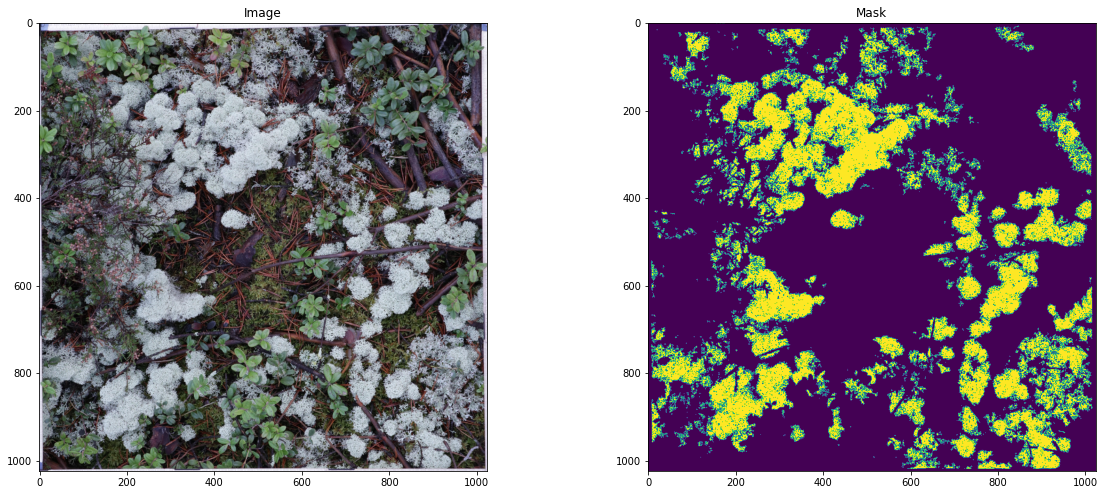

Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024, 1)
[0 1]
Sample number 2
Image name: downloaded_images/IMG_0201/IMG_0201.JPG
Mask name: downloaded_images/IMG_0201/IMG_0201_mask.JPG


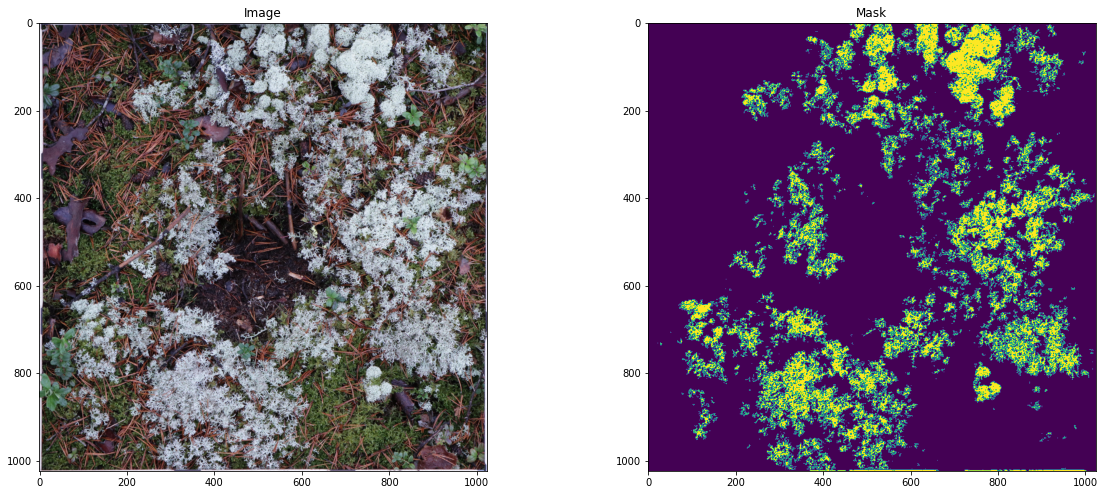

Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024, 1)
[0 1]


In [38]:
num_samples = 3
k = 0
for i in range(num_samples):
    plt.figure(figsize=(20, 28))
    print(f"Sample number {i}")
    image = train_set.__getitem__(0)[0][i]


    
    plt.subplot(num_samples, 2, 1 + k * 2)
    plt.imshow(image)
    plt.title("Image")
    mask = train_set.__getitem__(0)[1][i]
    
    plt.subplot(num_samples, 2, 2 + k*2)
    plt.imshow(mask)
    plt.title("Mask")
    print(f"Image name: {train_set.getImagePath(0, i)[0]}")
    print(f"Mask name: {train_set.getImagePath(0, i)[1]}")
    plt.show()

    print(f"Image shape: {np.shape(image)}\nMask shape: {np.shape(mask)}")
    print(np.unique(mask))

### Compile the model and train

In [8]:
# IOU metrics does not support from logits, add ooga booga support
import keras.metrics as tfm


class IOU(tfm.MeanIoU):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self._from_logits:
            super(IOU, self).update_state(y_true, tf.nn.softmax(y_pred), sample_weight=sample_weight)
        else:
            super(IOU, self).update_state(y_true, y_pred, sample_weight=sample_weight)



In [17]:

unet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.MeanIoU(num_classes=2)]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "lichens-segmentation.h5",
        save_best=True # Save the best weights and not necessarily the last
    )
]



epochs = 100 



unet.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
   
)


unet.load_weights("lichens-segmentation.h5")
unet.save("modelV2.h5")





Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'confusion_matrix/assert_less/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/manne/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/manne/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_49528/1397232319.py", line 20, in <module>
      unet.fit(
    File "/home/manne/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/metrics/metrics.py", line 2729, in update_state
      current_cm = tf.math.confusion_matrix(
Node: 'confusion_matrix/assert_less/Assert/AssertGuard/Assert'
Detected at node 'confusion_matrix/assert_less/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/manne/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/manne/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/manne/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/manne/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_49528/1397232319.py", line 20, in <module>
      unet.fit(
    File "/home/manne/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 998, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/manne/.local/lib/python3.8/site-packages/keras/metrics/metrics.py", line 2729, in update_state
      current_cm = tf.math.confusion_matrix(
Node: 'confusion_matrix/assert_less/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (confusion_matrix/Cast_2:0) = ] [1]
	 [[{{node confusion_matrix/assert_less/Assert/AssertGuard/Assert}}]]
	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/pivot_f/_31/_67]]
  (1) INVALID_ARGUMENT:  assertion failed: [`labels` out of bound] [Condition x < y did not hold element-wise:] [x (confusion_matrix/control_dependency:0) = ] [0 0 0...] [y (confusion_matrix/Cast_2:0) = ] [1]
	 [[{{node confusion_matrix/assert_less/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_69935]

2022-12-15 15:21:06.051091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 15:21:06.056461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 15:21:06.056607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 15:21:06.057109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-12-15 15:21:12.606619: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-12-15 15:21:13.588503: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12/12 [==============================] - 16s 316ms/step


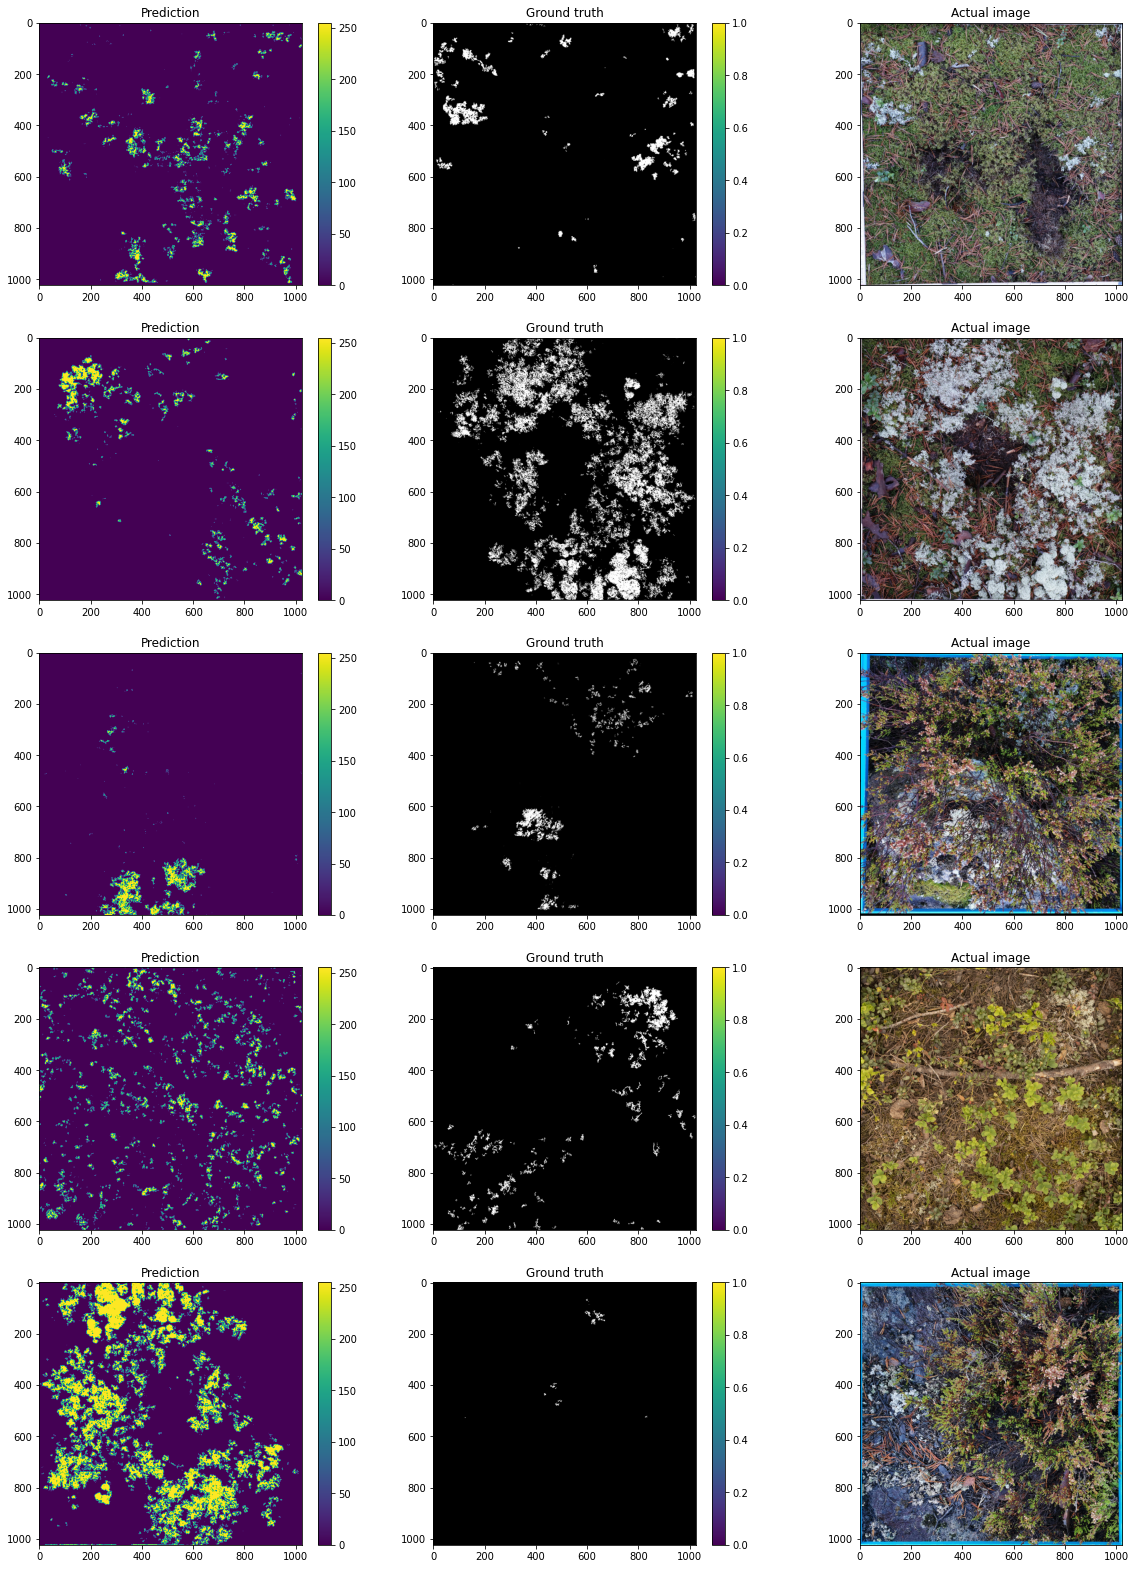

[-25.535852 -25.287388 -24.485064 ...  25.07713   26.789892  29.966728]


In [6]:

unet = keras.models.load_model("model.h5")
unet.load_weights("lichens-segmentation.h5")

# Note: val_set contains fewer images than the batch size which creates errors, this is why I tested naively on training data to see and indeication of the model performance
val_preds = unet.predict(val_set)

def get_pred(idx):
    mask = np.argmax(val_preds[idx], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img
    
NORM = mpl.colors.Normalize(vmin=0, vmax=num_classes - 1)

k = 0
n_examples = 5
plt.figure(figsize=(20, 28))
for i in range(n_examples):

    plt.subplot(n_examples, 3, 1 + k*3)

    # Show prediction
    pred = get_pred(i)
    plt.imshow(pred)
    
    plt.title(f"Prediction")
    plt.colorbar()
    plt.subplot(n_examples, 3, 2 + k*3)

    # Show ground truth
    plt.imshow(ImageOps.autocontrast(load_img(train_target_paths[i], color_mode="rgb", target_size=img_size)), norm=NORM)
    plt.title("Ground truth")
    plt.colorbar()
    plt.subplot(n_examples, 3, 3 + k*3)

    # Show image
    plt.imshow(load_img(train_img_paths[i], target_size=img_size))
    plt.title("Actual image")
    
    k += 1
    
plt.show()
print(np.unique(val_preds[0]))

In [ ]:

with open("done.txt", "w") as file:
    file.write(f"Execution time: {time.time() - start}")

In [20]:
keras.backend.clear_session()

: 

In [12]:

np.min(get_pred(0))

0

In [ ]:
np.min(val_set)
np.min(val_preds)

-210.61264